### Analysis and Data Collection by Caden Phan 

Scroll to bottom for all data visualization

*Disclaimer: Claude AI was used for debugging purposes throughout this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Data Loading and Initial Exploration Function

**Purpose:**
- Load a CSV file containing health and workout data
- Perform initial data exploration and preprocessing
- Handle potential data loading and conversion issues

**Key Operations:**
- Load CSV file
- Check for missing values in columns
- Convert date columns to datetime format
- Create new time-based features (hour, month, day of week)
- Convert duration to minutes
- Handle missing values through imputation or replacement

**Parameters:**
- `file_path`: String path to the CSV file to be loaded

**Returns:**
- Preprocessed pandas DataFrame
- Returns `None` if file loading fails

In [2]:
def load_and_explore_data(file_path):
    try:
        # Load the file using pandas with specified encoding
        df = pd.read_csv(file_path, encoding='latin1')
        print(f"Data loaded successfully, number of rows: {len(df)}")
        
        # Check for missing values in each column
        print("Missing values in each column:")
        print(df.isnull().sum())
        
        # Convert 'startDate' and 'endDate' to datetime format, handling errors gracefully
        df['startDate'] = pd.to_datetime(df['startDate'], errors='coerce')
        df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')
        
        # Verify if conversion was successful
        if df['startDate'].isnull().any():
            print("Some 'startDate' values could not be converted to datetime.")
        
        # Create new features from 'startDate' for analysis
        df['hour'] = df['startDate'].dt.hour
        df['month'] = df['startDate'].dt.month
        df['day_of_week'] = df['startDate'].dt.dayofweek
        
        # Convert 'duration' to numeric, handling non-numeric values
        df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
        df['duration_minutes'] = df['duration'] / 60  # Convert duration to minutes

        # Debug: Check the first few rows for new features
        print("Columns in DataFrame:", df.columns)
        print("Preview with 'duration_minutes' column:")
        print(df[['duration', 'duration_minutes']].head())
        
        # Handle missing values in other columns as desired
        df['totalDistance'] = df['totalDistance'].fillna(0)  # Replace NaNs with 0
        df['HKWeatherTemperature'] = df['HKWeatherTemperature'].fillna(df['HKWeatherTemperature'].mean())  # Impute with mean
        
        return df
    except FileNotFoundError:
        print(f"Error: Could not find file at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

### Duration Conversion Function

**Purpose:**
- Convert workout duration from seconds to minutes
- Add a new column to the DataFrame for duration in minutes

**Key Operations:**
- Divides 'duration' column by 60 to convert seconds to minutes
- Creates a new column 'duration_minutes'

**Parameters:**
- `df`: Pandas DataFrame containing workout data

**Returns:**
- DataFrame with added 'duration_minutes' column

In [3]:
def add_duration_minutes(df):
    # Convert 'duration' from seconds to minutes and add a new column 'duration_minutes'
    df['duration_minutes'] = df['duration'] / 60
    return df

### Calories vs. Workout Duration Analysis

**Purpose:**
- Create a scatter plot visualizing the relationship between workout duration and calories burned
- Color-code points by activity type

**Key Operations:**
- Ensures 'duration_minutes' column is present
- Uses seaborn to create a scatter plot
- X-axis represents workout duration in minutes
- Y-axis represents total calories burned
- Differentiates activity types using color

**Parameters:**
- `df`: Pandas DataFrame containing workout data

**Visualization Output:**
- Scatter plot showing calories burned across different workout durations

In [4]:
def analyze_calories_vs_duration(df):
    # Ensure 'duration_minutes' is created
    df = add_duration_minutes(df)
    
    # Check if the column is created correctly
    print("Columns in the DataFrame after adding 'duration_minutes':", df.columns)
    print("First few rows of the DataFrame with 'duration_minutes':\n", df[['duration', 'duration_minutes', 'totalEnergyBurned']].head())
    
    # Proceed with the plotting
    sns.scatterplot(data=df, x='duration_minutes', y='totalEnergyBurned', hue='activityType', alpha=0.6)
    plt.title('Calories Burned vs. Duration of Workout')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Calories Burned')
    plt.show()

### Metabolic Equivalent of Task (MET) Impact Analysis

**Purpose:**
- Explore the relationship between average METs and calories burned
- Visualize how different activity types relate to energy expenditure

**Key Operations:**
- Convert 'HKAverageMETs' to numeric values
- Remove rows with missing MET or calorie data
- Create a scatter plot of METs vs. calories burned
- Fit trend lines for each activity type

**Parameters:**
- `df`: Pandas DataFrame containing workout data

**Visualization Output:**
- Scatter plot with trend lines showing MET impact on calories burned
- Color-coded by activity type

In [5]:
def analyze_mets_impact(df):
    # Ensure 'HKAverageMETs' is numeric and handle errors
    df['HKAverageMETs'] = pd.to_numeric(df['HKAverageMETs'], errors='coerce')
    
    # Drop rows with NaN values in 'HKAverageMETs' or 'totalEnergyBurned'
    df_clean = df.dropna(subset=['HKAverageMETs', 'totalEnergyBurned'])
    plt.figure(figsize=(12, 6))
    scatter = sns.scatterplot(data=df_clean, x='HKAverageMETs', y='totalEnergyBurned', hue='activityType', alpha=0.6)
    
    # Initialize a list to keep track of the labels for the legend
    legend_labels = []
    
    # Fit a line for each activity type with an explicit label for the legend
    for activity in df_clean['activityType'].unique():
        activity_data = df_clean[df_clean['activityType'] == activity]
        z = np.polyfit(activity_data['HKAverageMETs'], activity_data['totalEnergyBurned'], 1)
        p = np.poly1d(z)
        line, = plt.plot(activity_data['HKAverageMETs'], p(activity_data['HKAverageMETs']), linestyle='--', alpha=0.8)
        # Add the activity type as a label for the line and store it
        legend_labels.append(line)
        line.set_label(f'Trend line for {activity}')
    
    plt.title('Calories Burned vs. Average METs')
    plt.xlabel('Average METs')
    plt.ylabel('Calories Burned')
    # Pass the list of labeled lines explicitly to the legend
    plt.legend(handles=legend_labels, title='Activity Type and Trend Lines')
    plt.show()

### Weather Impact on Workout Analysis

**Purpose:**
- Investigate how temperature and humidity affect calories burned
- Create side-by-side visualizations of weather conditions and energy expenditure

**Key Operations:**
- Clean temperature data by removing 'degF' and converting to float
- Create two subplots:
  1. Temperature vs. Calories Burned
  2. Humidity vs. Calories Burned
- Color-code points by activity type
- Customize axis labels and ticks

**Parameters:**
- `df`: Pandas DataFrame containing workout data

**Visualization Output:**
- Two-panel plot showing temperature and humidity effects on calories burned

In [6]:
def analyze_weather_impact(df):
    # Create a copy to avoid modifying original data
    df_plot = df.copy()
    
    # Clean temperature data by removing 'degF' and converting to numeric
    df_plot['HKWeatherTemperature'] = df_plot['HKWeatherTemperature'].str.replace(' degF', '').astype(float)
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # First plot - Temperature vs Calories
    sns.scatterplot(data=df_plot, x='HKWeatherTemperature', y='totalEnergyBurned', 
                   hue='activityType', ax=ax1, alpha=0.6)
    ax1.set_title('Temperature vs. Calories Burned')
    ax1.set_xlabel('Temperature (°F)')
    ax1.set_ylabel('Calories Burned')
    
    # Calculate reasonable tick positions for temperature
    temp_min = df_plot['HKWeatherTemperature'].min()
    temp_max = df_plot['HKWeatherTemperature'].max()
    # Create 5 evenly spaced ticks
    temp_ticks = np.linspace(temp_min, temp_max, 5)
    ax1.set_xticks(temp_ticks)
    # Format ticks to show no decimal places
    ax1.set_xticklabels([f'{x:.0f}' for x in temp_ticks])
    
    # Second plot - Humidity vs Calories
    sns.scatterplot(data=df_plot, x='HKWeatherHumidity', y='totalEnergyBurned', 
                   hue='activityType', ax=ax2, alpha=0.6)
    ax2.set_title('Humidity vs. Calories Burned')
    ax2.set_xlabel('Humidity (%)')
    ax2.set_ylabel('Calories Burned')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

### Workout Time of Day Analysis

**Purpose:**
- Categorize workouts into time periods
- Visualize calories burned across different times of day
- Compare activity types and their energy expenditure

**Key Operations:**
- Categorize hours into periods:
  - Night (0-6)
  - Morning (6-12)
  - Afternoon (12-18)
  - Evening (18-24)
- Create a box plot showing calorie distribution
- Color-code by activity type

**Parameters:**
- `df`: Pandas DataFrame containing workout data

**Visualization Output:**
- Box plot showing calories burned by time of day
- Differentiated by activity type

In [7]:
def analyze_time_of_day(df):
    # Ensure 'startDate' is in datetime format and extract the hour
    if 'hour' not in df.columns:
        df['startDate'] = pd.to_datetime(df['startDate'], errors='coerce')  # Convert 'startDate' to datetime if needed
        df['hour'] = df['startDate'].dt.hour  # Extract the hour

    # Create time categories based on the 'hour' column
    df['time_category'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)'])

    # Plot the calories burned by time of day
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='time_category', y='totalEnergyBurned', hue='activityType')
    plt.title('Calories Burned by Time of Day')
    plt.xlabel('Time of Day')
    plt.ylabel('Calories Burned')
    plt.xticks(rotation=45)
    plt.legend(title='Activity Type')
    plt.tight_layout()
    plt.show()

### Monthly Workout Consistency Analysis

**Purpose:**
- Track workout frequency across different months
- Visualize the distribution of workout types over time

**Key Operations:**
- Group workouts by month and activity type
- Create a stacked bar plot showing workout count
- Ensure month information is available

**Parameters:**
- `df`: Pandas DataFrame containing workout data

**Visualization Output:**
- Stacked bar chart showing number of workouts per month
- Broken down by activity type

In [8]:
def analyze_workout_consistency(df):
    # Ensure 'month' exists before grouping by checking and adding it if necessary
    if 'month' not in df.columns:
        df['month'] = df['startDate'].dt.month
    monthly_workouts = df.groupby(['month', 'activityType']).size().unstack(fill_value=0)
    
    # Plot directly using monthly_workouts.plot() without plt.figure()
    ax = monthly_workouts.plot(kind='bar', stacked=True, figsize=(12, 6))
    ax.set_title('Workout Frequency by Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Workouts')
    ax.legend(title='Activity Type')
    plt.tight_layout()
    plt.show()

### Main Execution Function

**Purpose:**
- Serve as the entry point for the health data analysis script
- Load data
- Perform initial data cleaning
- Compute basic statistics
- Call various analysis functions to generate insights

**Key Operations:**
- Load CSV file
- Check for missing values
- Clean 'totalEnergyBurned' column
- Print basic statistics:
  - Workout counts by activity type
  - Average calories burned per activity type
- Call analysis functions to generate visualizations

In [9]:
def main():
    # Load the data (assuming it's already loaded correctly)
    df = pd.read_csv('health.csv')  # Replace with your actual file path if needed
    print(f"Data loaded successfully, number of rows: {len(df)}")
    
    # Check for missing values
    print("\nMissing values in each column:")
    print(df.isnull().sum())

    # Clean 'totalEnergyBurned' by removing the 'kcal' unit and converting to numeric
    df['totalEnergyBurned'] = df['totalEnergyBurned'].str.replace(' kcal', '', regex=False).astype(float)

    # Basic statistics
    print("\nBasic Statistics:")

    # Workout Counts by Activity Type
    print("\nWorkout Counts by Activity Type:")
    print(df['activityType'].value_counts())

    # Average Calories Burned by Activity Type
    print("\nAverage Calories Burned by Activity Type:")
    print(df.groupby('activityType')['totalEnergyBurned'].mean())
 
    # Run the various analyses
    analyze_calories_vs_duration(df)
    analyze_mets_impact(df)
    analyze_weather_impact(df)
    analyze_time_of_day(df)
    analyze_workout_consistency(df)

Data loaded successfully, number of rows: 893

Missing values in each column:
startDate                 0
endDate                   0
activityType              0
duration                  0
durationUnit              0
totalEnergyBurned         0
totalDistance           623
HKTimeZone                0
HKWeatherTemperature     48
HKAverageMETs             1
HKWeatherHumidity        48
dtype: int64

Basic Statistics:

Workout Counts by Activity Type:
activityType
TraditionalStrengthTraining    623
Running                        270
Name: count, dtype: int64

Average Calories Burned by Activity Type:
activityType
Running                        245.678145
TraditionalStrengthTraining    632.937942
Name: totalEnergyBurned, dtype: float64
Columns in the DataFrame after adding 'duration_minutes': Index(['startDate', 'endDate', 'activityType', 'duration', 'durationUnit',
       'totalEnergyBurned', 'totalDistance', 'HKTimeZone',
       'HKWeatherTemperature', 'HKAverageMETs', 'HKWeatherHumidity'

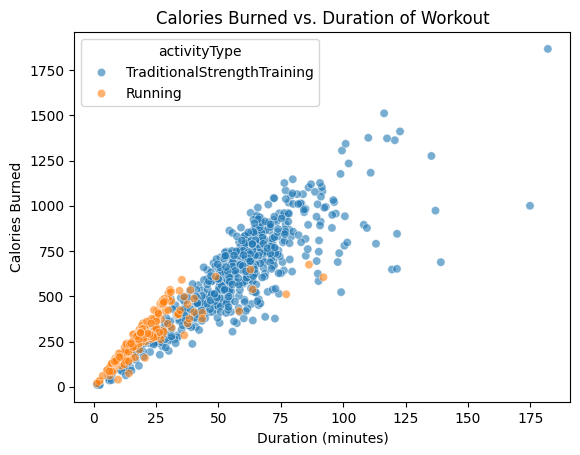

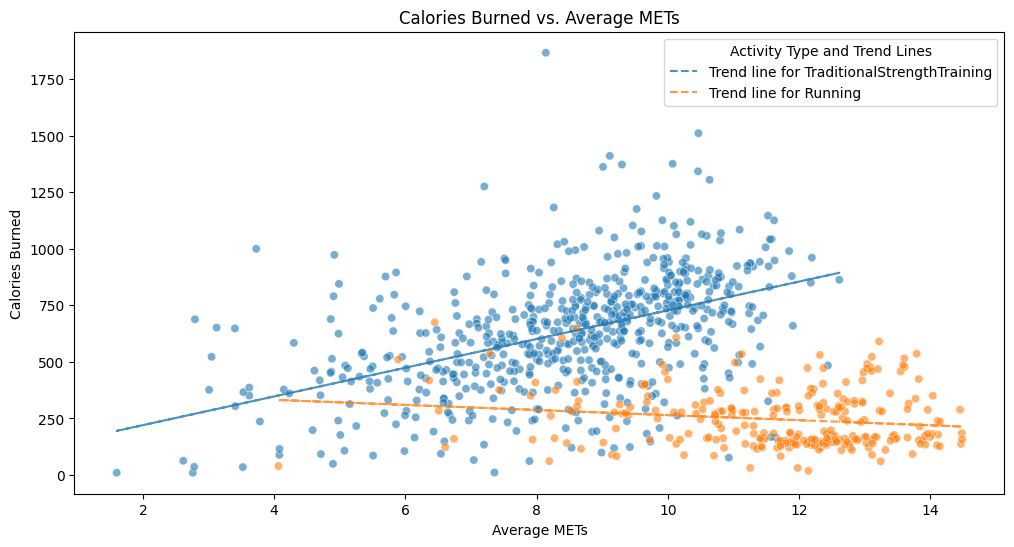

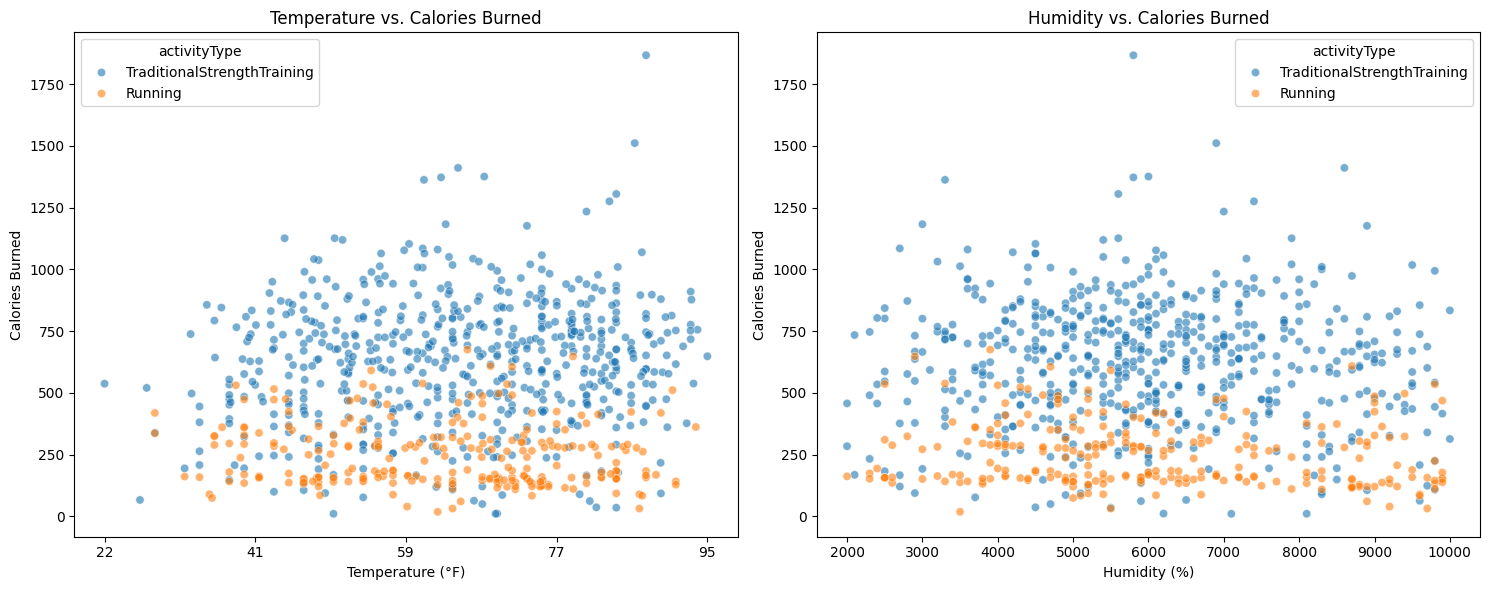

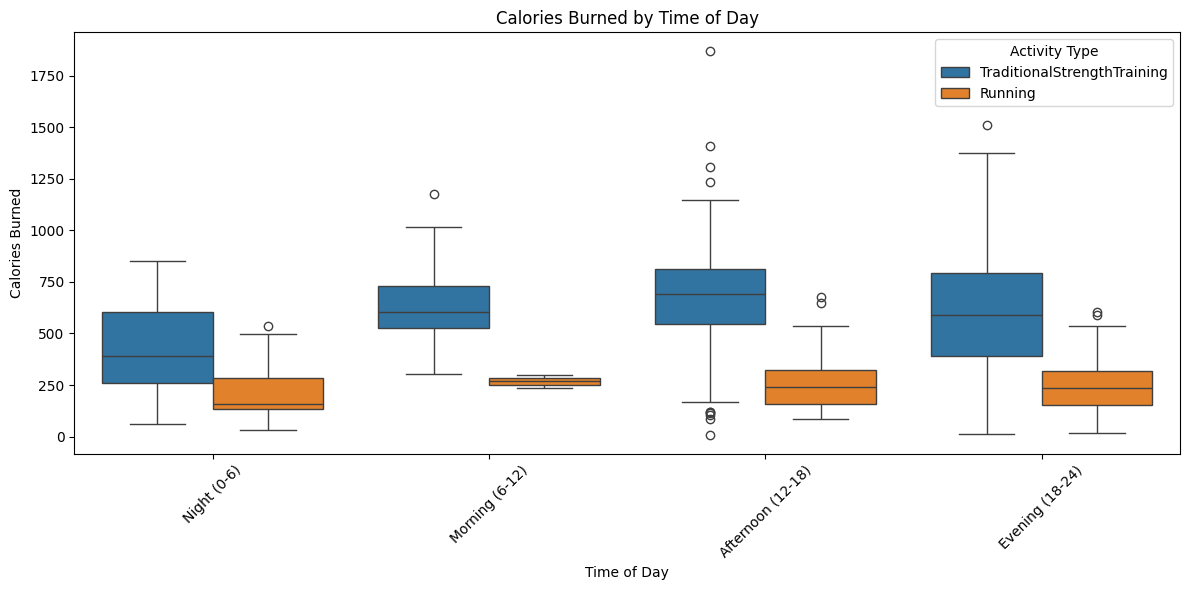

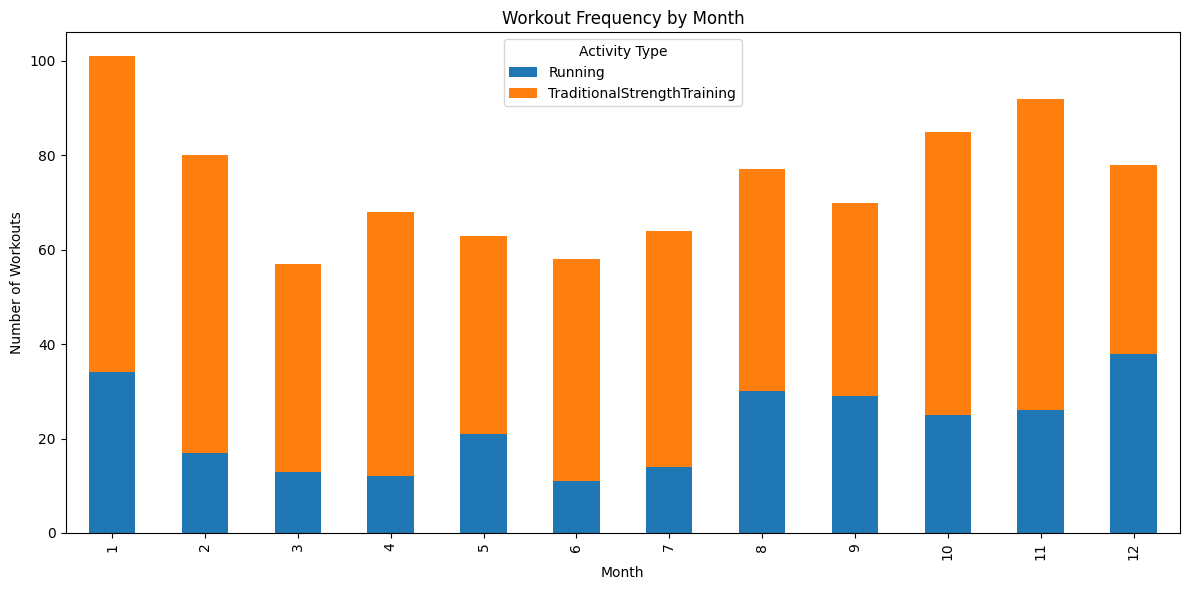

In [10]:
if __name__ == "__main__":
    main()